In [0]:
class CyclicLR():
    def __init__(self, base_lr=1e-7, max_lr=1e-2, step_size=200,
                 mode='triangular', gamma=1., scale_fn=None, scale_mode='cycle'):
        super().__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        self.scale_mode = scale_mode
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2. ** (x-1))
            elif self.mode == 'circular':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        
        self._reset()
        
    def _reset(self, new_base_lr=None, new_max_lr=None, new_step_size=None):
        if new_base_lr != None:
            self.base_lr = new_base_lr
            
        if new_max_lr != None:
            self.max_lr = new_max_lr
            
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.basr_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)

In [0]:
class LRFinder:
    def __init__(self, model, train, optimizer, criterion):
#         self.model = model
        self.model = copy.deepcopy(model)
        self.train = train
        self.criterion = criterion
        self.optimizer = optimizer
    
    def find_lr(self, init_value = 1e-8, final_value=10., beta = 0.98):
        num = len(self.train)-1
        mult = (final_value / init_value) ** (1/num)
        lr = init_value
        optimizer.param_groups[0]['lr'] = lr
        avg_loss = 0.
        best_loss = 0.
        batch_num = 0
        losses = []
        log_lrs = []
        for data in tqdm(self.train):
            batch_num += 1
#             import pdb; pdb.set_trace();
            #As before, get the loss for this mini-batch of inputs/outputs
            inputs,labels = data
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            #Compute the smoothed loss
            avg_loss = beta * avg_loss + (1-beta) *loss.data
            smoothed_loss = avg_loss / (1 - beta**batch_num)
            #Stop if the loss is exploding
            if batch_num > 1 and smoothed_loss > 4 * best_loss:
                return log_lrs, losses
            #Record the best loss
            if smoothed_loss < best_loss or batch_num==1:
                best_loss = smoothed_loss
            #Store the values
            losses.append(smoothed_loss)
            log_lrs.append(np.log10(lr))
            #Do the SGD step
            loss.backward()
            self.optimizer.step()
            #Update the lr for the next step
            lr *= mult
            self.optimizer.param_groups[0]['lr'] = lr
        return log_lrs, losses

In [0]:
def extract_data(url, fname=None, dest=None, force_download=False):
    from urllib.request import urlopen
    from zipfile import ZipFile
    import os
    import shutil
    from pathlib import Path
    import tarfile
    filename = url.rpartition('/')[2]
    foldername = filename.split('.')[0]
    if os.path.exists(f'{dest}/{foldername}'):
        print('Already Downloaded')
        if force_download:
            print('Removing Old Downloaded')
            shutil.rmtree(f'{dest}/{foldername}')
        else:
            return Path(f'{dest}/{foldername}')
    print('Downloading from remote server')
    response = urlopen(url)
    if dest is None: dest = '.'
    tmpzip = open(f'{dest}/{filename}', 'wb')
    tmpzip.write(response.read())
    tmpzip.close()
    if (filename.endswith("zip")):
        zf = ZipFile(f'{dest}/{filename}')
        zf.extractall(path = dest)
        zf.close()
    elif (filename.endswith("tar.gz") or filename.endswith("tgz")):
        tar = tarfile.open(f'{dest}/{filename}', "r:gz")
        tar.extractall(path = dest)
        tar.close()
    elif (filename.endswith("tar")):
        tar = tarfile.open(f'{dest}/{filename}', "r:")
        tar.extractall(path = dest)
        tar.close()
    os.remove(f'{dest}/{filename}')
    return Path(f'{dest}/{foldername}')

## Code Start

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
import matplotlib.pyplot as plt
import time
import os
import copy
from pathlib import Path
from PIL import Image
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm
from torch.utils.data.sampler import SequentialSampler, RandomSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
path = extract_data('https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz', dest='sample_data')
list(iter(path.iterdir()))

[PosixPath('sample_data/oxford-iiit-pet/annotations'),
 PosixPath('sample_data/oxford-iiit-pet/images')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

In [32]:
files = list(iter(path_img.iterdir())); files[:5]

[PosixPath('sample_data/oxford-iiit-pet/images/chihuahua_129.jpg'),
 PosixPath('sample_data/oxford-iiit-pet/images/Bengal_123.jpg'),
 PosixPath('sample_data/oxford-iiit-pet/images/Birman_93.jpg'),
 PosixPath('sample_data/oxford-iiit-pet/images/Ragdoll_199.jpg'),
 PosixPath('sample_data/oxford-iiit-pet/images/Siamese_186.jpg')]

In [33]:
list(iter(path_anno.iterdir()))

[PosixPath('sample_data/oxford-iiit-pet/annotations/trimaps'),
 PosixPath('sample_data/oxford-iiit-pet/annotations/README'),
 PosixPath('sample_data/oxford-iiit-pet/annotations/._trimaps'),
 PosixPath('sample_data/oxford-iiit-pet/annotations/test.txt'),
 PosixPath('sample_data/oxford-iiit-pet/annotations/list.txt'),
 PosixPath('sample_data/oxford-iiit-pet/annotations/trainval.txt'),
 PosixPath('sample_data/oxford-iiit-pet/annotations/xmls')]

In [0]:
size=224
batch = 64 
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(*imagenet_stats), 
    ]),
    'valid': transforms.Compose([
        transforms.RandomResizedCrop(size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(*imagenet_stats),
    ]),
}

In [0]:
class PetsDataset(Dataset):
    def __init__(self, root_dir, files, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        self.classes, self.filenames, self.target = PetsDataset._get_classes(files)
        self.c = len(self.classes)
        self.len = len(self.filenames)
        self.class_2_idx = {self.classes[i]:i for i in range(len(self.classes))}
        self.idx_2_class = {v:k for k,v in self.class_2_idx.items()}
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        img_name = self.filenames[index]
        target = self.class_2_idx[self.target[index]]
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        image = image / 255
        data = (image, target)
        
        return data
        
    
    @classmethod
    def _get_classes(cls, files):
        names = set()
        file_names = []
        target = []
        for i, file in enumerate(files):
            file_names.append(file)
            name = file.name.rpartition('_')[0].lower()
            target.append(name)
            names.add(name)
        return list(names), file_names, target

In [0]:
full_datasets = PetsDataset(path, files, data_transforms['train'])

In [38]:
print(full_datasets.classes)
train_datasets.c

['english_setter', 'english_cocker_spaniel', 'american_pit_bull_terrier', 'bengal', 'havanese', 'pug', 'egyptian_mau', 'siamese', 'sphynx', 'japanese_chin', 'persian', 'saint_bernard', 'leonberger', 'great_pyrenees', 'ragdoll', 'russian_blue', 'birman', 'beagle', 'basset_hound', 'boxer', 'shiba_inu', 'keeshond', 'abyssinian', 'german_shorthaired', 'staffordshire_bull_terrier', 'wheaten_terrier', 'scottish_terrier', 'british_shorthair', 'american_bulldog', 'maine_coon', 'bombay', 'yorkshire_terrier', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'samoyed', 'chihuahua']


37

In [39]:
train_size = int(0.8 * len(full_datasets))
test_size = len(full_datasets) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(full_datasets, [train_size, test_size])
train_size, len(train_dataset), test_size, len(test_dataset)

(5912, 5912, 1478, 1478)

In [0]:
train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
valid_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

loader = {
    'train': train_dataloader,
    'valid': valid_dataloader
}

In [0]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, train_datasets.c)
model = model.cuda()

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [53]:
lrf = LRFinder(model, loader['train'], optimizer, criterion)
log_lrs, losses = lrf.find_lr()

In [0]:
# !rm -rf /content/sample_data/oxford-iiit-pet/images/*.mat

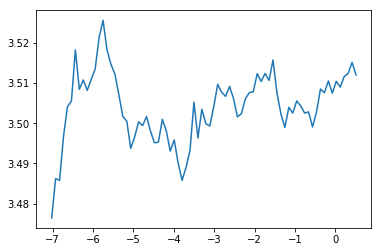

In [54]:
fig, ax = plt.subplots(1,1)
ax.plot(log_lrs[10:-5],losses[10:-5])

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    clr_triangular = CyclicLR(mode='triangular', max_lr=optimizer.param_groups[0]['lr'])
    optimizer.param_groups[0]['lr'] = clr_triangular.base_lr
    
    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
#                 scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                clr_triangular.clr_iterations += 1
                clr_triangular.trn_iterations += 1
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                lr = clr_triangular.clr()
                optimizer.param_groups[0]['lr'] = lr
                clr_triangular.history.setdefault('iterations', []).append(clr_triangular.trn_iterations)
                clr_triangular.history.setdefault('lr', []).append(lr)
                clr_triangular.history.setdefault('loss', []).append(loss)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, clr_triangular

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [56]:
model, clr_triangular = train_model(model, loader, criterion, optimizer, num_epochs=3)

Epoch 0/2
----------


train Loss: 3.2435 Acc: 0.1538


valid Loss: 2.8174 Acc: 0.3735

Epoch 1/2
----------


train Loss: 2.5128 Acc: 0.6269


valid Loss: 2.1644 Acc: 0.7206

Epoch 2/2
----------


train Loss: 2.0008 Acc: 0.7419


valid Loss: 1.8170 Acc: 0.7903

Training complete in 3m 45s
Best val Acc: 0.790257


In [57]:
model, clr_triangular = train_model(model, loader, criterion, optimizer, num_epochs=5)

Epoch 0/4
----------


train Loss: 1.8428 Acc: 0.7661


valid Loss: 1.7958 Acc: 0.7652

Epoch 1/4
----------


train Loss: 1.7778 Acc: 0.7786


valid Loss: 1.6812 Acc: 0.7882

Epoch 2/4
----------


train Loss: 1.6784 Acc: 0.7881


valid Loss: 1.6091 Acc: 0.7882

Epoch 3/4
----------


train Loss: 1.6518 Acc: 0.7909


valid Loss: 1.6008 Acc: 0.7774

Epoch 4/4
----------


train Loss: 1.6294 Acc: 0.7821


valid Loss: 1.5431 Acc: 0.8004

Training complete in 6m 15s
Best val Acc: 0.800406


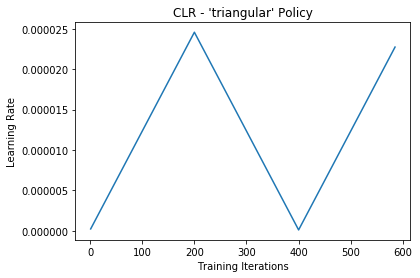

In [58]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [0]:
# class AdaptiveConcatPool2d(nn.Module):
#     "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
#     def __init__(self, sz=None):
#         "Output will be 2*sz or 2 if sz is None"
#         super().__init__()
#         self.output_size = sz or 1
#         self.ap = nn.AdaptiveAvgPool2d(self.output_size)
#         self.mp = nn.AdaptiveMaxPool2d(self.output_size)
#     def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)


In [0]:
# class Flatten(nn.Module):
#     "Flatten `x` to a single dimension, often used at the end of a model. `full` for rank-1 tensor"
#     def __init__(self, full=False):
#         super().__init__()
#         self.full = full

#     def forward(self, x):
#         return x.view(-1) if self.full else x.view(x.size(0), -1)

In [0]:
# layer = nn.Sequential(
#     AdaptiveConcatPool2d(),
#     Flatten(),
#     nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#     nn.Dropout(p=0.25),
#     nn.Linear(in_features=1024, out_features=512, bias=True),
#     nn.ReLU(True),
#     nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#     nn.Dropout(p=0.5),
#     nn.Linear(in_features=512, out_features=37, bias=True)
# )

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    [
        {"params": model.fc.parameters(), "lr": 1e-4},
        {"params": model.layer4.parameters(), 'lr': 1e-5},
        {"params": model.layer3.parameters(), 'lr': 1e-5},
        {"params": model.layer2.parameters(), 'lr': 1e-6},
        {"params": model.layer1.parameters(), 'lr': 1e-6},
    ],
    lr=1e-7,
)

In [61]:
model, clr_triangular = train_model(model, loader, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------


train Loss: 1.5534 Acc: 0.7989


valid Loss: 1.4596 Acc: 0.7930

Epoch 1/9
----------


train Loss: 1.3695 Acc: 0.7953


valid Loss: 1.2298 Acc: 0.8004

Epoch 2/9
----------


train Loss: 1.1903 Acc: 0.8068


valid Loss: 1.0873 Acc: 0.8315

Epoch 3/9
----------


train Loss: 1.1089 Acc: 0.8217


valid Loss: 1.0435 Acc: 0.8241

Epoch 4/9
----------


train Loss: 1.0640 Acc: 0.8200


valid Loss: 0.9734 Acc: 0.8329

Epoch 5/9
----------


train Loss: 0.9786 Acc: 0.8253


valid Loss: 0.8910 Acc: 0.8227

Epoch 6/9
----------


train Loss: 0.9072 Acc: 0.8363


valid Loss: 0.8335 Acc: 0.8336

Epoch 7/9
----------


train Loss: 0.8862 Acc: 0.8356


valid Loss: 0.8492 Acc: 0.8187

Epoch 8/9
----------


train Loss: 0.8529 Acc: 0.8327


valid Loss: 0.7743 Acc: 0.8315

Epoch 9/9
----------


train Loss: 0.8084 Acc: 0.8344


valid Loss: 0.7693 Acc: 0.8349

Training complete in 12m 32s
Best val Acc: 0.834912
